### Ячейка 1: Импорты

In [1]:
print("Установка flashlight-text...")
!pip install flashlight-text
print("Установка flashlight-text завершена (или уже установлена).")

Установка flashlight-text...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.9 MB/s eta 0:00:0000:01
Установка flashlight-text завершена (или уже установлена).


In [2]:
!pip install editdistance --quiet
!pip install jiwer --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 46.4 MB/s eta 0:00:00a 0:00:01


In [3]:
import torch
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.fft # Для розового шума

import pandas as pd
import numpy as np
import os
import time
import random
import traceback
import json # Для сохранения/загрузки конфига в чекпоинт

# Метрики и утилиты
import editdistance
import jiwer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# Beam Search декодер (Опционально)
try:
    from torchaudio.models.decoder import ctc_decoder
    TORCHAUDIO_CTC_DECODER_AVAILABLE = True
    print("Фабричная функция `ctc_decoder` импортирована.")
except ImportError:
    TORCHAUDIO_CTC_DECODER_AVAILABLE = False
    ctc_decoder = None
    print("Предупреждение: `torchaudio.models.decoder.ctc_decoder` не найден.")
    print("Для Beam Search установите: !pip install flashlight-text --no-deps --quiet")
    print("!!! И ПЕРЕЗАПУСТИТЕ СРЕДУ ВЫПОЛНЕНИЯ !!!")

# --- Версии и Устройство ---
print(f"\nPyTorch Version: {torch.__version__}")
print(f"Torchaudio Version: {torchaudio.__version__}")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {DEVICE} ({torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'})")

Фабричная функция `ctc_decoder` импортирована.

PyTorch Version: 2.5.1+cu124
Torchaudio Version: 2.5.1+cu124
Device: cuda (Tesla P100-PCIE-16GB)


### Ячейка 2: Конфигурация Эксперимента

In [4]:
config = {
    # --- Основные Настройки ---
    "SEED": 42,
    "KAGGLE_INPUT_DIR": '/kaggle/input/morse-dataset/data',
    "KAGGLE_WORKING_DIR": '/kaggle/working/',
    "MODEL_NAME": "morse_crnn_4layer_norm_aug_v1", # Имя для этого эксперимента

    # --- Пути (формируются автоматически ниже) ---
    "TRAIN_CSV_PATH": None, "TEST_CSV_PATH": None, "SAMPLE_SUBMISSION_PATH": None,
    "AUDIO_BASE_PATH": None, "CHECKPOINT_DIR": None, "LOG_FILE": None, "SUBMISSION_FILE": None,

    # --- Имена колонок ---
    "FILE_PATH_COLUMN": 'id', "TARGET_COLUMN": 'message', "TEST_ID_COLUMN": 'id',

    # --- Параметры Аудио и Mel-спектрограмм ---
    "AUDIO": {
        "sample_rate": 8000, "n_mels": 64, "n_fft": 400,
        "hop_length": 160, "win_length": 400,
        "amplitude_to_db": True, # Конвертировать в dB для входа в модель? (Обычно да)
        "top_db": 80,
    },

    # --- Параметры Предобработки (Применяются всегда к Train/Val/Test) ---
    "PREPROCESSING": {
        "normalize": { # RMS Нормализация Waveform
            "apply": True,
            "target_dbfs": -23.0,
            "silence_threshold_db": -60
        },
        "frequency_filter": { # Фильтрация Mel-бинов
            "apply": True,
            "min_mel_bin": 12,
            "max_mel_bin": 40,
            "mask_value": None # None -> использовать min() спектрограммы
        }
    },

    "AUGMENTATION": {
        "probability": 0.9,
        "active": ['time_shift', 'gain', 'noise', 'pitch_shift', 'freq_masking'], 
        "time_shift": {
            "max_fraction": 0.1,
        },
        "gain": {
            "db_range": (-8.0, 4.0),
        },
        "noise": {
            "snr_db_range": (0, 20),
            "types_prob": {
                'gaussian': 0.6,
                'pink': 0.4,
            }
        },
        "pitch_shift": {

            "n_steps_range": (-1.5, 1.5)
        },
        "freq_masking": {
             "masks": 2,
             "width": 8,
        }
    },

    # --- Параметры Обучения ---
    "TRAINING": {
        "batch_size":   128,
        "num_workers": 4,
        "learning_rate": 3e-4,
        "num_epochs": 40, # Увеличим немного для данных с аугментацией
        "validation_split_size": 0.1,
        "optimizer": "AdamW",
        "optimizer_weight_decay": 1e-5,
        "scheduler": "ReduceLROnPlateau", # Или "CosineAnnealingLR"
        "scheduler_patience": 5,         # Для ReduceLROnPlateau
        "scheduler_factor": 0.5,         # Для ReduceLROnPlateau
        "grad_clip_value": 1.0           # Ограничение градиента (0 - отключено)
    },

    # --- Параметры Модели (CRNN 4-слойная) ---
    "MODEL": {
        "type": "CRNNModel_4Layer",
        "rnn_hidden_size": 256,
        "rnn_num_layers": 2,
        "cnn_dropout": 0.15,
        "rnn_dropout": 0.15
    },

    # --- Параметры Инференса ---
    "INFERENCE": {
        "batch_size": 64, # Можно увеличить для инференса
        "use_beam_search": True, # Пытаться использовать Beam Search?
        "beam_search_beam_size": 15,
        "beam_search_lm_path": None, # Путь к языковой модели (если есть)
        "beam_search_lexicon_path": None, # Путь к лексикону (если есть)
    }
}

# --- Формирование Путей ---
config["TRAIN_CSV_PATH"] = os.path.join(config["KAGGLE_INPUT_DIR"], 'train.csv')
config["TEST_CSV_PATH"] = os.path.join(config["KAGGLE_INPUT_DIR"], 'test.csv')
config["SAMPLE_SUBMISSION_PATH"] = os.path.join(config["KAGGLE_INPUT_DIR"], 'sample_submission.csv')
config["AUDIO_BASE_PATH"] = os.path.join(config["KAGGLE_INPUT_DIR"], 'morse_dataset', 'morse_dataset')
config["CHECKPOINT_DIR"] = os.path.join(config["KAGGLE_WORKING_DIR"], f"checkpoints_{config['MODEL_NAME']}")
config["LOG_FILE"] = os.path.join(config["KAGGLE_WORKING_DIR"], f"training_log_{config['MODEL_NAME']}.txt")
config["SUBMISSION_FILE"] = os.path.join(config["KAGGLE_WORKING_DIR"], f"submission_{config['MODEL_NAME']}.csv")

# --- Создание Папок и Установка SEED ---
os.makedirs(config["CHECKPOINT_DIR"], exist_ok=True)
def seed_everything(seed):
    random.seed(seed); os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False
seed_everything(config["SEED"])

# --- Вывод основной конфигурации ---
print(f"\n--- Конфигурация Запуска: {config['MODEL_NAME']} ---")
print(f"Предобработка: Normalize={config['PREPROCESSING']['normalize']['apply']}, FreqFilter={config['PREPROCESSING']['frequency_filter']['apply']}")
print(f"Аугментации (Prob={config['AUGMENTATION']['probability']}): {config['AUGMENTATION']['active']}")
print(f"Модель: {config['MODEL']['type']} ({config['MODEL']['rnn_hidden_size']} hidden, {config['MODEL']['rnn_num_layers']} layers)")
print(f"Обучение: {config['TRAINING']['num_epochs']} эпох, BS={config['TRAINING']['batch_size']}, LR={config['TRAINING']['learning_rate']}, Optim={config['TRAINING']['optimizer']}, Sched={config['TRAINING']['scheduler']}")
print(f"Инференс: BeamSearch={config['INFERENCE']['use_beam_search'] and TORCHAUDIO_CTC_DECODER_AVAILABLE}, BeamSize={config['INFERENCE']['beam_search_beam_size']}")
print(f"Чекпоинты: {config['CHECKPOINT_DIR']}")


--- Конфигурация Запуска: morse_crnn_4layer_norm_aug_v1 ---
Предобработка: Normalize=True, FreqFilter=True
Аугментации (Prob=0.9): ['time_shift', 'gain', 'noise', 'pitch_shift', 'freq_masking']
Модель: CRNNModel_4Layer (256 hidden, 2 layers)
Обучение: 40 эпох, BS=128, LR=0.0003, Optim=AdamW, Sched=ReduceLROnPlateau
Инференс: BeamSearch=True, BeamSize=15
Чекпоинты: /kaggle/working/checkpoints_morse_crnn_4layer_norm_aug_v1


### Ячейка 3: Утилиты (Декодирование, Метрики)

In [5]:
BLANK_CHAR = '<blank>'
char_to_int = None
int_to_char = None
blank_index = -1

# Функции decode_predictions, decode_targets, calculate_levenshtein_mean - БЕЗ ИЗМЕНЕНИЙ
# (Скопируйте их из вашего предыдущего "чистого" ноутбука)
def decode_predictions(log_probs: torch.Tensor, int_to_char_map: dict, blank_idx: int) -> list[str]:
    """ Простое жадное CTC-декодирование (Greedy Best Path) """
    decoded_preds = []
    if log_probs.numel() == 0: return []
    log_probs_cpu = log_probs.cpu().detach()
    best_paths = torch.argmax(log_probs_cpu, dim=2) # [Time, Batch] -> [Batch, Time] если batch_first=True в LSTM? Нет, LSTM отдает [T, B, H], FC [T, B, C], log_softmax [T, B, C] - все верно
    # Нужно убедиться, что log_probs имеет форму [Time, Batch, Classes] - стандартный выход LSTM+Linear в PyTorch
    best_paths = torch.argmax(log_probs_cpu, dim=2) # [Time, Batch]
    for i in range(best_paths.shape[1]): # Iterate over batch
        best_path_i = best_paths[:, i].tolist()
        decoded_seq = []
        last_char_idx = blank_idx
        for char_idx in best_path_i:
            if char_idx != blank_idx and char_idx != last_char_idx:
                decoded_seq.append(int_to_char_map.get(char_idx, '?'))
            last_char_idx = char_idx
        decoded_preds.append("".join(decoded_seq))
    return decoded_preds

def decode_targets(targets: torch.Tensor, target_lengths: torch.Tensor, int_to_char_map: dict) -> list[str]:
    """ Декодирует батч таргетов (конкатенированных) из индексов в строки """
    decoded_targets_list = []
    start_idx = 0
    targets_cpu = targets.cpu().tolist(); target_lengths_cpu = target_lengths.cpu().tolist()
    for length in target_lengths_cpu:
        if length == 0: decoded_targets_list.append(""); continue
        target_indices = targets_cpu[start_idx : start_idx + length]
        decoded_target = "".join([int_to_char_map.get(idx, '?') for idx in target_indices])
        decoded_targets_list.append(decoded_target)
        start_idx += length
    return decoded_targets_list

def calculate_levenshtein_mean(predictions: list[str], targets: list[str]) -> float:
    """ Расчет среднего расстояния Левенштейна """
    if not predictions or not targets or len(predictions) != len(targets): return float('inf')
    total_distance, num_samples = 0, len(targets)
    if num_samples == 0: return 0.0
    for pred, target in zip(predictions, targets):
        total_distance += editdistance.eval(str(pred), str(target))
    return total_distance / num_samples

# Функция для расчета CER
def calculate_cer(predictions: list[str], targets: list[str]) -> float:
    """ Расчет среднего CER с помощью jiwer """
    if not predictions or not targets or len(predictions) != len(targets): return float('inf')
    if not jiwer: return float('nan') # Если jiwer не установлен
    try:
        # Убедимся, что нет пустых таргетов, jiwer их не любит
        filtered_preds = [p for p, t in zip(predictions, targets) if t]
        filtered_targets = [t for t in targets if t]
        if not filtered_targets: return 0.0
        return jiwer.cer(filtered_targets, filtered_preds)
    except Exception as e:
        print(f"Ошибка расчета CER: {e}")
        return float('nan')

print("Утилиты декодирования и метрики определены.")

Утилиты декодирования и метрики определены.


### Ячейка 4: Вспомогательные Функции (Предобработка, Аугментации)

In [6]:
# Функции generate_pink_noise, apply_rms_normalization, apply_time_shift,
# apply_gain, add_noise - БЕЗ ИЗМЕНЕНИЙ
# (Скопируйте их из вашего ноутбука для анализа аугментаций Ячейка 3 + Ячейка 4а)
def generate_pink_noise(shape, sr, device=None):
    n_samples = shape[-1]
    if n_samples == 0: return torch.zeros(shape, device=device)
    white_noise = torch.randn(shape, device=device)
    fft_white = torch.fft.rfft(white_noise, dim=-1)
    freqs = torch.fft.rfftfreq(n_samples, d=1.0/sr, device=device) # Используем sample_rate
    scaling_factor = 1.0 / torch.sqrt(torch.clamp(freqs, min=1e-6))
    if len(scaling_factor)>0: scaling_factor[0] = 1.0
    fft_pink = fft_white * scaling_factor
    pink_noise = torch.fft.irfft(fft_pink, n=n_samples, dim=-1)
    std_white = torch.std(white_noise); std_pink = torch.std(pink_noise)
    if std_pink > 1e-6: pink_noise = pink_noise * (std_white / std_pink)
    return pink_noise

def apply_rms_normalization(waveform, sr, target_dbfs=-20.0, silence_threshold_db=-60):
    if waveform.numel() == 0: return waveform
    try:
        current_loudness_lufs = F.loudness(waveform, sr)
        if current_loudness_lufs < silence_threshold_db: return waveform
        gain_db = target_dbfs - current_loudness_lufs
        gain_factor = 10.0 ** (gain_db / 20.0)
        normalized_waveform = torch.clamp(waveform * gain_factor, min=-1.0, max=1.0)
        return normalized_waveform
    except Exception: return waveform

def apply_time_shift(waveform, sr, max_fraction=0.1):
    if waveform.numel() == 0: return waveform
    max_shift_samples = int(waveform.shape[1] * max_fraction)
    if max_shift_samples == 0: return waveform
    shift_amount = random.randint(-max_shift_samples, max_shift_samples)
    return torch.roll(waveform, shifts=shift_amount, dims=1)

def apply_gain(waveform, db_range=(-6.0, 6.0)):
    if waveform.numel() == 0: return waveform
    gain_db = random.uniform(db_range[0], db_range[1])
    gain_factor = 10.0 ** (gain_db / 20.0)
    return torch.clamp(waveform * gain_factor, min=-1.0, max=1.0)

def add_noise(waveform, sr, snr_db_range=(10, 30), types_prob={'gaussian': 1.0}):
    if waveform.numel() == 0: return waveform
    noise_types = list(types_prob.keys())
    probs = np.array(list(types_prob.values()), dtype=np.float32)
    prob_sum = probs.sum()
    if prob_sum <= 0: return waveform
    if not np.isclose(prob_sum, 1.0): probs /= prob_sum
    chosen_noise_type = np.random.choice(noise_types, p=probs)
    noise = None
    if chosen_noise_type == 'gaussian': noise = torch.randn_like(waveform)
    elif chosen_noise_type == 'pink': noise = generate_pink_noise(waveform.shape, sr, device=waveform.device)
    else: return waveform
    if noise is None or noise.shape != waveform.shape: return waveform
    snr_db = random.uniform(snr_db_range[0], snr_db_range[1])
    snr_linear = 10.0 ** (snr_db / 10.0)
    waveform_power = torch.mean(waveform**2)
    if waveform_power < 1e-9: return waveform
    noise_power_target = waveform_power / snr_linear
    noise_power_current = torch.mean(noise**2)
    if noise_power_current < 1e-9: return waveform
    noise_scaled = noise * torch.sqrt(noise_power_target / noise_power_current)
    return torch.clamp(waveform + noise_scaled, min=-1.0, max=1.0)

# Функция apply_frequency_filter - БЕЗ ИЗМЕНЕНИЙ
# (Скопируйте из вашего ноутбука для анализа аугментаций Ячейка 3)
def apply_frequency_filter(spectrogram, min_bin, max_bin, mask_value=None):
    if spectrogram is None or spectrogram.numel() == 0: return spectrogram
    filtered_spec = spectrogram.clone()
    fill_value = mask_value if mask_value is not None else filtered_spec.min().item()
    if min_bin > 0: filtered_spec[:min_bin, :] = fill_value
    if max_bin < filtered_spec.shape[0] - 1: filtered_spec[max_bin + 1:, :] = fill_value
    return filtered_spec

# Функция для Frequency Masking
def apply_freq_masking(spectrogram, max_masks=1, max_width=10):
    if spectrogram.numel() == 0 or max_masks <= 0 or max_width <= 0: return spectrogram
    num_masks = random.randint(0, max_masks)
    if num_masks == 0: return spectrogram

    transform = T.FrequencyMasking(freq_mask_param=random.randint(1, max_width))
    # FrequencyMasking ожидает [..., Freq, Time]
    # Наша спектрограмма [Freq, Time], добавим батч/канал временно
    masked_spec = spectrogram.clone().unsqueeze(0).unsqueeze(0) # [1, 1, Freq, Time]
    for _ in range(num_masks):
        masked_spec = transform(masked_spec)
    return masked_spec.squeeze(0).squeeze(0) # [Freq, Time]
    
def apply_pitch_shift(waveform, sr, n_steps_range=(-1.0, 1.0)):
    """Применяет случайный сдвиг высоты тона."""
    if waveform.numel() == 0: return waveform
    
    # Выбираем случайное количество полутонов для сдвига
    n_steps = random.uniform(n_steps_range[0], n_steps_range[1])
    if abs(n_steps) < 1e-3: return waveform # Небольшой сдвиг можно пропустить
    
    try:
        # Используем torchaudio.functional.pitch_shift
        shifted_waveform = F.pitch_shift(waveform, sample_rate=sr, n_steps=n_steps)
        return shifted_waveform
    except Exception as e:
        # print(f"Ошибка pitch_shift: {e}") # Ошибки могут возникать при некоторых граничных условиях
        return waveform # Возвращаем оригинал в случае ошибки

print("Функция apply_pitch_shift определена.")

print("Вспомогательные функции (предобработка, аугментации) определены.")

Функция apply_pitch_shift определена.
Вспомогательные функции (предобработка, аугментации) определены.


### Ячейка 5: Класс MorseDataset (с Предобработкой и Аугментациями)

In [7]:
# ==============================================================================
# Ячейка 5: Класс MorseDataset (с Предобработкой и Аугментациями)
# ==============================================================================

class MorseDataset(Dataset):
    def __init__(self, data_frame: pd.DataFrame, audio_base_path: str, char_map: dict,
                 file_path_column: str, target_column: str,
                 # --- Конфигурации ---
                 audio_cfg: dict,
                 preproc_cfg: dict,
                 aug_cfg: dict = None, # None для val/test
                 is_train: bool = False # Флаг для применения аугментаций
                 ):

        self.data_frame = data_frame.reset_index(drop=True)
        self.audio_base_path = audio_base_path
        self.char_map = char_map
        self.file_path_column = file_path_column
        self.target_column = target_column
        self.test_id_column = config["TEST_ID_COLUMN"] # Глобальный конфиг

        # Сохраняем конфигурации
        self.audio_cfg = audio_cfg
        self.preproc_cfg = preproc_cfg
        self.aug_cfg = aug_cfg if is_train else None # Аугментации только для трейна
        self.is_train = is_train

        # Сохраняем параметры для быстрого доступа
        self.target_sr = audio_cfg['sample_rate']
        self.apply_norm = preproc_cfg['normalize']['apply']
        self.norm_target_dbfs = preproc_cfg['normalize']['target_dbfs']
        self.norm_silence_db = preproc_cfg['normalize']['silence_threshold_db']
        self.apply_freq_filter = preproc_cfg['frequency_filter']['apply']
        self.min_bin = preproc_cfg['frequency_filter']['min_mel_bin']
        self.max_bin = preproc_cfg['frequency_filter']['max_mel_bin']
        self.filter_mask_value = preproc_cfg['frequency_filter']['mask_value']

        # Параметры аугментации (только если is_train и aug_cfg переданы)
        if self.is_train and self.aug_cfg:
             self.aug_prob = self.aug_cfg['probability']
             self.active_augs = self.aug_cfg['active']
             # Time Shift
             self.apply_time_shift = 'time_shift' in self.active_augs
             self.time_shift_fraction = self.aug_cfg.get('time_shift', {}).get('max_fraction', 0.1)
             # Gain
             self.apply_gain = 'gain' in self.active_augs
             self.gain_range = self.aug_cfg.get('gain', {}).get('db_range', (-6.0, 6.0))
             # Noise
             self.apply_noise = 'noise' in self.active_augs
             self.noise_snr = self.aug_cfg.get('noise', {}).get('snr_db_range', (10, 30))
             self.noise_types = self.aug_cfg.get('noise', {}).get('types_prob', {'gaussian': 1.0})
             # Pitch Shift
             self.apply_pitch_shift = 'pitch_shift' in self.active_augs
             self.pitch_shift_range = self.aug_cfg.get('pitch_shift', {}).get('n_steps_range', (-1.0, 1.0))
             # Frequency Masking
             self.apply_freq_mask = 'freq_masking' in self.active_augs
             self.freq_mask_count = self.aug_cfg.get('freq_masking', {}).get('masks', 0)
             self.freq_mask_width = self.aug_cfg.get('freq_masking', {}).get('width', 0)
        else:
             # Устанавливаем значения по умолчанию, если аугментации не применяются
             self.aug_prob = 0.0
             self.active_augs = []
             self.apply_time_shift = False
             self.apply_gain = False
             self.apply_noise = False
             self.apply_pitch_shift = False
             self.apply_freq_mask = False


        # Mel трансформатор (создается один раз)
        self.mel_transform = T.MelSpectrogram(
            sample_rate=self.target_sr, n_fft=audio_cfg['n_fft'],
            win_length=audio_cfg['win_length'], hop_length=audio_cfg['hop_length'],
            n_mels=audio_cfg['n_mels'] )
        # Опционально: DB трансформатор
        self.db_transform = T.AmplitudeToDB(top_db=audio_cfg['top_db']) if audio_cfg.get('amplitude_to_db', False) else None

    def __len__(self):
        return len(self.data_frame)

    def _load_audio(self, audio_path):
        try:
            waveform, sr = torchaudio.load(audio_path)
            # 1. Ресемплинг
            if sr != self.target_sr:
                resampler = T.Resample(orig_freq=sr, new_freq=self.target_sr)
                waveform = resampler(waveform)
            # 2. В Моно
            if waveform.shape[0] > 1: waveform = torch.mean(waveform, dim=0, keepdim=True)
            # 3. Гарантируем [1, Time]
            if waveform.dim() == 1: waveform = waveform.unsqueeze(0)
            return waveform
        except Exception as e:
            # print(f"Ошибка загрузки {os.path.basename(audio_path)}: {e}") # Раскомментировать для отладки
            return None

    def __getitem__(self, idx):
        try:
            if torch.is_tensor(idx): idx = idx.tolist()
            row = self.data_frame.iloc[idx]
            audio_rel_path = str(row[self.file_path_column])
        except Exception as e:
            # print(f"Ошибка доступа к DataFrame, idx={idx}: {e}")
            return None
        if not audio_rel_path.endswith('.opus'): audio_rel_path += '.opus'
        audio_full_path = os.path.join(self.audio_base_path, audio_rel_path)

        # 1. Загрузка Waveform
        waveform = self._load_audio(audio_full_path)
        if waveform is None or waveform.numel() == 0:
            # print(f"Пропуск: Не удалось загрузить или пустой файл: {audio_rel_path}")
            return None

        # 2. Предобработка Waveform (Применяется всегда)
        if self.apply_norm:
            waveform = apply_rms_normalization(waveform, self.target_sr, self.norm_target_dbfs, self.norm_silence_db)

        # Флаг, сработала ли общая вероятность аугментации для этого сэмпла
        apply_augs_to_this_sample = self.is_train and self.aug_cfg and random.random() < self.aug_prob

        # 3. Аугментация Waveform (Только для Train и если сработала общая вероятность)
        if apply_augs_to_this_sample:
            # Собираем список активных waveform аугментаций
            waveform_augs_to_apply = [aug for aug in self.active_augs if aug != 'freq_masking']
            random.shuffle(waveform_augs_to_apply) # Применяем в случайном порядке
            for aug_name in waveform_augs_to_apply:
                 if aug_name == 'time_shift' and self.apply_time_shift:
                     waveform = apply_time_shift(waveform, self.target_sr, self.time_shift_fraction)
                 elif aug_name == 'gain' and self.apply_gain:
                     waveform = apply_gain(waveform, self.gain_range)
                 elif aug_name == 'noise' and self.apply_noise:
                     waveform = add_noise(waveform, self.target_sr, self.noise_snr, self.noise_types)
                 elif aug_name == 'pitch_shift' and self.apply_pitch_shift:
                     waveform = apply_pitch_shift(waveform, self.target_sr, self.pitch_shift_range)
                 # Добавьте сюда другие waveform аугментации при необходимости

        # 4. Генерация Mel-Спектрограммы
        try:
            features = self.mel_transform(waveform) # [1, Freq, Time]
            features = features.squeeze(0) # -> [Freq, Time]
            if self.db_transform:
                 features = self.db_transform(features)
        except Exception as e:
            # print(f"Ошибка Mel/DB трансформации для {audio_rel_path}: {e}")
            return None

        # 5. Предобработка Спектрограммы (Применяется всегда)
        if self.apply_freq_filter and features.numel() > 0:
            features = apply_frequency_filter(features, self.min_bin, self.max_bin, self.filter_mask_value)

        # 6. Аугментация Спектрограммы (Только для Train и если сработала общая вероятность)
        if apply_augs_to_this_sample and self.apply_freq_mask:
             features = apply_freq_masking(features, self.freq_mask_count, self.freq_mask_width)

        # 7. Подготовка Выхода
        if self.char_map: # Train/Val
            try:
                target_text = str(row[self.target_column])
                encoded_text = [self.char_map.get(char) for char in target_text if char in self.char_map]
                # Пропускаем сэмплы с пустыми или невалидными таргетами ПОСЛЕ маппинга
                if not encoded_text:
                     # print(f"Пропуск: Пустой или невалидный таргет после маппинга для {audio_rel_path}, target='{target_text}'")
                     return None
                encoded_text = torch.tensor(encoded_text, dtype=torch.long)
                return features, encoded_text
            except Exception as e:
                # print(f"Ошибка обработки таргета для {audio_rel_path}: {e}")
                return None
        else: # Test
            try:
                test_id = str(row[self.test_id_column])
                return features, test_id
            except Exception as e:
                 # print(f"Ошибка получения test_id для {audio_rel_path}: {e}")
                 return None

print("Класс MorseDataset (с предобработкой и аугментациями, вкл. Pitch Shift) определен.")

Класс MorseDataset (с предобработкой и аугментациями, вкл. Pitch Shift) определен.


### Ячейка 6: Функции Collate

In [8]:
# Функции collate_fn и collate_fn_test - БЕЗ ИЗМЕНЕНИЙ
# (Скопируйте их из вашего предыдущего ноутбука)
def collate_fn(batch):
    batch = [item for item in batch if item is not None]
    if not batch: return torch.tensor([]), torch.tensor([]), torch.tensor([]), torch.tensor([])
    features = [item[0].T for item in batch] # [Time, Freq]
    texts = [item[1] for item in batch]
    features_padded = pad_sequence(features, batch_first=True, padding_value=0.0) # [Batch, Time, Freq]
    features_padded = features_padded.permute(0, 2, 1) # -> [Batch, Freq, Time]
    input_lengths = torch.tensor([f.shape[1] for item in batch for f in [item[0]]], dtype=torch.long)
    targets = torch.cat(texts, dim=0)
    target_lengths = torch.tensor([len(text) for text in texts], dtype=torch.long)
    return features_padded, input_lengths, targets, target_lengths

def collate_fn_test(batch):
    batch = [item for item in batch if item is not None]
    if not batch: return torch.tensor([]), torch.tensor([]), []
    features = [item[0].T for item in batch] # [Time, Freq]
    ids = [item[1] for item in batch]
    features_padded = pad_sequence(features, batch_first=True, padding_value=0.0) # [Batch, Time, Freq]
    features_padded = features_padded.permute(0, 2, 1) # -> [Batch, Freq, Time]
    input_lengths = torch.tensor([f.shape[1] for item in batch for f in [item[0]]], dtype=torch.long)
    return features_padded, input_lengths, ids

print("Функции collate_fn и collate_fn_test определены.")

Функции collate_fn и collate_fn_test определены.


### Ячейка 7: Класс Модели (CRNNModel_4Layer)

In [9]:
# Класс CRNNModel_4Layer - БЕЗ ИЗМЕНЕНИЙ
# (Скопируйте его из вашего ноутбука с 4-слойной моделью)
class CRNNModel_4Layer(nn.Module):
    def __init__(self, n_features, num_classes, rnn_hidden_size=256,
                 num_rnn_layers=2, cnn_dropout=0.15, rnn_dropout=0.15):
        super().__init__()
        self.n_features = n_features
        self.num_classes = num_classes
        self.rnn_hidden_size = rnn_hidden_size
        self.time_reduction_factor = 16 # Важно! 2*2*2*2 по времени

        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # F/2, T/2
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)), # F/4, T/4
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2)), # F/4, T/8
            nn.Conv2d(128, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(kernel_size=(1, 2), stride=(1, 2))  # F/4, T/16
        )
        self.cnn_dropout = nn.Dropout(cnn_dropout)

        with torch.no_grad():
            dummy_input = torch.randn(1, 1, self.n_features, 512)
            cnn_out = self.cnn(dummy_input)
            self.cnn_output_features = cnn_out.shape[1] * cnn_out.shape[2]
            print(f"Модель {self.__class__.__name__}: Выход CNN для RNN = {self.cnn_output_features} признаков (C={cnn_out.shape[1]}, F'={cnn_out.shape[2]})")
            print(f"Модель {self.__class__.__name__}: Фактор сокращения времени CNN = {self.time_reduction_factor}x")

        actual_rnn_dropout = rnn_dropout if num_rnn_layers > 1 else 0.0
        self.rnn = nn.LSTM(
            input_size=self.cnn_output_features, hidden_size=self.rnn_hidden_size,
            num_layers=num_rnn_layers, bidirectional=True, batch_first=False,
            dropout=actual_rnn_dropout)

        self.layer_norm = nn.LayerNorm(2 * self.rnn_hidden_size)
        self.fc = nn.Linear(2 * self.rnn_hidden_size, num_classes)

    def _calculate_output_lengths(self, input_lengths: torch.Tensor) -> torch.Tensor:
        output_lengths = torch.div(input_lengths, self.time_reduction_factor, rounding_mode='floor')
        return torch.clamp(output_lengths, min=1).long()

    def forward(self, x: torch.Tensor, input_lengths: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        x = x.unsqueeze(1) # [B, 1, F, T]
        x = self.cnn(x)    # [B, C, F', T']
        output_lengths = self._calculate_output_lengths(input_lengths)
        N, Ch, F_prime, T_prime = x.shape
        x = x.permute(3, 0, 1, 2) # [T', B, C, F']
        x = x.reshape(T_prime, N, Ch * F_prime) # [T', B, Features]
        x = self.cnn_dropout(x)
        x, _ = self.rnn(x)      # [T', B, 2*H]
        x = self.layer_norm(x)
        x = self.fc(x)          # [T', B, N_Classes]
        log_probs = F.log_softmax(x, dim=2)
        return log_probs, output_lengths

print(f"Класс модели {config['MODEL']['type']} определен.")

Класс модели CRNNModel_4Layer определен.


### Ячейка 8: Загрузка Метаданных и Создание Алфавита

In [10]:
print("\nЗагрузка метаданных и создание алфавита...")
try:
    train_df_full = pd.read_csv(config["TRAIN_CSV_PATH"])
except FileNotFoundError as e: print(f"Ошибка: {e}"); raise
train_df_full[config["TARGET_COLUMN"]] = train_df_full[config["TARGET_COLUMN"]].fillna('').astype(str)
train_df_filtered = train_df_full[train_df_full[config["TARGET_COLUMN"]].str.len() > 0].copy()
print(f"Записей для обучения (после фильтрации): {len(train_df_filtered)}")
if len(train_df_filtered) == 0: raise ValueError("Нет валидных таргетов!")

# Создание алфавита
all_chars = set(train_df_filtered[config["TARGET_COLUMN"]].str.cat(sep=''))
chars = [BLANK_CHAR] + sorted(list(all_chars))
char_to_int = {char: i for i, char in enumerate(chars)}
int_to_char = {i: char for i, char in enumerate(chars)}
NUM_CLASSES = len(chars)
blank_index = char_to_int[BLANK_CHAR]
print(f"Алфавит создан ({NUM_CLASSES} классов). Blank: '{BLANK_CHAR}' ({blank_index})")
print(f"Символы: {''.join(chars)}")


Загрузка метаданных и создание алфавита...
Записей для обучения (после фильтрации): 30000
Алфавит создан (45 классов). Blank: '<blank>' (0)
Символы: <blank> #0123456789АБВГДЕЖЗИЙКЛМНОПРСТУФХЦЧШЩЪЫЬЭЮЯ


### Ячейка 9: Подготовка Данных (Сплит, Датасеты, Лоадеры)

In [11]:
print("\nПодготовка данных для обучения...")

# --- Сплит ---
train_df, val_df = train_test_split(
    train_df_filtered,
    test_size=config['TRAINING']['validation_split_size'],
    random_state=config['SEED']
)
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
print(f"Размеры выборок: Train={len(train_df)}, Validation={len(val_df)}")

# --- Датасеты ---
train_dataset = MorseDataset(
    data_frame=train_df, audio_base_path=config["AUDIO_BASE_PATH"], char_map=char_to_int,
    file_path_column=config["FILE_PATH_COLUMN"], target_column=config["TARGET_COLUMN"],
    audio_cfg=config["AUDIO"], preproc_cfg=config["PREPROCESSING"], aug_cfg=config["AUGMENTATION"],
    is_train=True
)
val_dataset = MorseDataset(
    data_frame=val_df, audio_base_path=config["AUDIO_BASE_PATH"], char_map=char_to_int,
    file_path_column=config["FILE_PATH_COLUMN"], target_column=config["TARGET_COLUMN"],
    audio_cfg=config["AUDIO"], preproc_cfg=config["PREPROCESSING"], aug_cfg=None, # Нет аугментаций для val
    is_train=False
)
print("Датасеты созданы.")

# --- Лоадеры ---
train_loader = DataLoader(
    train_dataset, batch_size=config['TRAINING']['batch_size'], shuffle=True,
    collate_fn=collate_fn, num_workers=config['TRAINING']['num_workers'],
    pin_memory=torch.cuda.is_available(), persistent_workers=(config['TRAINING']['num_workers'] > 0)
)
val_loader = DataLoader(
    val_dataset, batch_size=config['INFERENCE']['batch_size'], shuffle=False, # Используем инференс BS для val
    collate_fn=collate_fn, num_workers=config['TRAINING']['num_workers'],
    pin_memory=torch.cuda.is_available(), persistent_workers=(config['TRAINING']['num_workers'] > 0)
)
print("Лоадеры созданы.")


Подготовка данных для обучения...
Размеры выборок: Train=27000, Validation=3000
Датасеты созданы.
Лоадеры созданы.


### Ячейка 10: Настройка Обучения (Модель, Лосс, Оптимизатор, Планировщик)

In [12]:
print("\nНастройка компонентов обучения...")

# --- Модель ---
# Убедимся, что класс модели соответствует конфигу (здесь CRNNModel_4Layer)
if config['MODEL']['type'] == 'CRNNModel_4Layer':
    model = CRNNModel_4Layer(
        n_features=config['AUDIO']['n_mels'], num_classes=NUM_CLASSES,
        rnn_hidden_size=config['MODEL']['rnn_hidden_size'], num_rnn_layers=config['MODEL']['rnn_num_layers'],
        cnn_dropout=config['MODEL']['cnn_dropout'], rnn_dropout=config['MODEL']['rnn_dropout']
    ).to(DEVICE)
else:
    raise ValueError(f"Неизвестный тип модели в конфиге: {config['MODEL']['type']}")

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Модель {config['MODEL']['type']} создана ({num_params:,} параметров) на {DEVICE}.")

# --- Функция Потерь ---
criterion = nn.CTCLoss(blank=blank_index, reduction='mean', zero_infinity=True).to(DEVICE)

# --- Оптимизатор ---
lr = config['TRAINING']['learning_rate']
wd = config['TRAINING']['optimizer_weight_decay']
if config['TRAINING']['optimizer'] == 'AdamW':
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=wd)
elif config['TRAINING']['optimizer'] == 'Adam':
     optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
else:
     raise ValueError(f"Неизвестный оптимизатор: {config['TRAINING']['optimizer']}")
print(f"Оптимизатор: {config['TRAINING']['optimizer']} (LR={lr}, WD={wd})")

# --- Планировщик ---
scheduler = None
if config['TRAINING']['scheduler'] == 'ReduceLROnPlateau':
    scheduler = ReduceLROnPlateau(optimizer, mode='min',
                                  factor=config['TRAINING']['scheduler_factor'],
                                  patience=config['TRAINING']['scheduler_patience'],
                                  verbose=True)
elif config['TRAINING']['scheduler'] == 'CosineAnnealingLR':
    scheduler = CosineAnnealingLR(optimizer, T_max=config['TRAINING']['num_epochs'], eta_min=lr / 100)
elif config['TRAINING']['scheduler'] is not None and config['TRAINING']['scheduler'] != 'None':
     raise ValueError(f"Неизвестный планировщик: {config['TRAINING']['scheduler']}")
print(f"Планировщик: {config['TRAINING']['scheduler']}")


Настройка компонентов обучения...
Модель CRNNModel_4Layer: Выход CNN для RNN = 2048 признаков (C=128, F'=16)
Модель CRNNModel_4Layer: Фактор сокращения времени CNN = 16x
Модель CRNNModel_4Layer создана (6,564,717 параметров) на cuda.
Оптимизатор: AdamW (LR=0.0003, WD=1e-05)
Планировщик: ReduceLROnPlateau


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


### Ячейка 11: Цикл Обучения

In [13]:

history = {'train_loss': [], 'val_loss': [], 'val_metric': [], 'val_cer': []}
best_val_metric = float('inf')
best_epoch = -1

# --- Логирование ---
if os.path.exists(config["LOG_FILE"]): os.remove(config["LOG_FILE"])
log_header = "Epoch,Train Loss,Val Loss,Val Levenshtein,Val CER,Time(s),LR\n"
with open(config["LOG_FILE"], "w") as f: f.write(log_header)
print(log_header.strip())
print(f"\n--- Старт Обучения ({config['TRAINING']['num_epochs']} эпох на {DEVICE}) ---")

start_time_total = time.time()
# --- Основной Цикл ---
for epoch in range(config['TRAINING']['num_epochs']):
    epoch_start_time = time.time()
    # === Фаза Обучения ===
    model.train()
    train_loss_epoch = 0.0; train_batches = 0
    train_iter = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['TRAINING']['num_epochs']} [Train]", leave=False)

    for batch_idx, batch in enumerate(train_iter):
        try:
            if not isinstance(batch, (tuple, list)) or len(batch) != 4 or batch[0].numel() == 0:
                # print(f"Пропуск некорректного батча (Train): {type(batch)}, len={len(batch) if isinstance(batch, (tuple, list)) else 'N/A'}")
                continue
            spec_batch, spec_len_batch, target_batch, target_len_batch = batch
            spec_batch, target_batch, target_len_batch = spec_batch.to(DEVICE), target_batch.to(DEVICE), target_len_batch.to(DEVICE)

            optimizer.zero_grad()
            # input_lengths должны быть на CPU для .div в _calculate_output_lengths, но модель ожидает их на DEVICE? Проверим
            log_probs, output_lengths = model(spec_batch, spec_len_batch.to(DEVICE)) # Передаем длины на device

            # Убедимся что output_lengths не превышает T' log_probs
            output_lengths = torch.clamp(output_lengths, max=log_probs.shape[0])

            loss = criterion(log_probs, target_batch, output_lengths.cpu(), target_len_batch.cpu())

            # Проверка на NaN/inf
            if torch.isnan(loss) or torch.isinf(loss):
                 print(f"\nПредупреждение: NaN/inf loss на трейне (эпоха {epoch+1}, батч {batch_idx}). Пропуск батча.")
                 continue

            loss.backward()
            # Ограничение градиента
            if config['TRAINING']['grad_clip_value'] > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), config['TRAINING']['grad_clip_value'])
            optimizer.step()

            train_loss_epoch += loss.item(); train_batches += 1
            if batch_idx % 20 == 0:
                train_iter.set_postfix(loss=f"{train_loss_epoch / train_batches:.4f}")

        except Exception as e:
            print(f"\nОшибка обучения (эпоха {epoch+1}, батч {batch_idx}): {e}")
            traceback.print_exc()
            continue # Пропускаем ошибочный батч

    avg_train_loss = train_loss_epoch / train_batches if train_batches > 0 else float('nan')

    # === Фаза Валидации ===
    model.eval()
    val_loss_epoch = 0.0; val_batches = 0
    all_val_preds, all_val_targets = [], []
    val_iter = tqdm(val_loader, desc=f"Epoch {epoch+1}/{config['TRAINING']['num_epochs']} [Val]", leave=False)

    with torch.no_grad():
        for batch_idx, batch in enumerate(val_iter):
            try:
                if not isinstance(batch, (tuple, list)) or len(batch) != 4 or batch[0].numel() == 0:
                     # print(f"Пропуск некорректного батча (Val): {type(batch)}, len={len(batch) if isinstance(batch, (tuple, list)) else 'N/A'}")
                     continue
                spec_batch, spec_len_batch, target_batch, target_len_batch = batch
                spec_batch, target_batch, target_len_batch = spec_batch.to(DEVICE), target_batch.to(DEVICE), target_len_batch.to(DEVICE)

                log_probs, output_lengths = model(spec_batch, spec_len_batch.to(DEVICE))
                output_lengths = torch.clamp(output_lengths, max=log_probs.shape[0])

                loss = criterion(log_probs, target_batch, output_lengths.cpu(), target_len_batch.cpu())

                if not torch.isnan(loss) and not torch.isinf(loss):
                    val_loss_epoch += loss.item(); val_batches += 1

                # Декодирование Greedy для метрик (быстрее для валидации)
                batch_preds = decode_predictions(log_probs, int_to_char, blank_index)
                batch_targets = decode_targets(target_batch, target_len_batch, int_to_char)
                all_val_preds.extend(batch_preds); all_val_targets.extend(batch_targets)

            except Exception as e:
                 print(f"\nОшибка валидации (эпоха {epoch+1}, батч {batch_idx}): {e}")
                 traceback.print_exc()
                 continue

    avg_val_loss = val_loss_epoch / val_batches if val_batches > 0 else float('nan')
    val_levenshtein = calculate_levenshtein_mean(all_val_preds, all_val_targets)
    val_cer = calculate_cer(all_val_preds, all_val_targets)
    history['train_loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    history['val_metric'].append(val_levenshtein)
    history['val_cer'].append(val_cer)

    epoch_time = time.time() - epoch_start_time
    current_lr = optimizer.param_groups[0]['lr']

    # --- Логирование ---
    log_str = f"E{epoch+1:02d} [{epoch_time:.1f}s] | TrL={avg_train_loss:.4f} | VL={avg_val_loss:.4f} | VLev={val_levenshtein:.4f} | VCER={val_cer:.4f} | LR={current_lr:.1e}"
    print(log_str)
    with open(config["LOG_FILE"], "a") as f:
        f.write(f"{epoch+1},{avg_train_loss:.4f},{avg_val_loss:.4f},{val_levenshtein:.4f},{val_cer:.4f},{epoch_time:.1f},{current_lr:.1e}\n")

    # --- Шаг Планировщика ---
    if scheduler:
      if isinstance(scheduler, ReduceLROnPlateau):
          scheduler.step(val_levenshtein) # Используем Levenshtein для ReduceLROnPlateau
      elif isinstance(scheduler, CosineAnnealingLR):
          scheduler.step()

    # --- Сохранение лучшей модели ---
    if val_levenshtein < best_val_metric:
        best_val_metric = val_levenshtein
        best_epoch = epoch + 1
        checkpoint_path = os.path.join(config["CHECKPOINT_DIR"], f"{config['MODEL_NAME']}_best_ep{best_epoch}_lev{val_levenshtein:.4f}.pth")
        try:
            # Сохраняем конфиг вместе с моделью
            save_dict = {
                'epoch': best_epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict() if scheduler else None,
                'val_metric': best_val_metric,
                'char_to_int': char_to_int,
                'int_to_char': int_to_char,
                'blank_index': blank_index,
                'config': config # Сохраняем весь конфиг
            }
            torch.save(save_dict, checkpoint_path)
            print(f"  -> Best model saved: {os.path.basename(checkpoint_path)}")
        except Exception as e: print(f"Ошибка сохранения чекпоинта: {e}")

# --- Завершение ---
total_training_time = time.time() - start_time_total
print(f"\n--- Training Finished ({total_training_time/60:.1f} min) ---")
if best_epoch != -1: print(f"Best Val Levenshtein: {best_val_metric:.4f} at epoch {best_epoch}")
else: print("Модель не сохранялась."); print(f"Logs: {config['LOG_FILE']}"); print(f"Checkpoints: {config['CHECKPOINT_DIR']}")





Epoch,Train Loss,Val Loss,Val Levenshtein,Val CER,Time(s),LR

--- Старт Обучения (40 эпох на cuda) ---


Epoch 1/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 1/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E01 [283.1s] | TrL=4.0501 | VL=4.0045 | VLev=8.9110 | VCER=1.0000 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep1_lev8.9110.pth


Epoch 2/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 2/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E02 [244.8s] | TrL=3.9941 | VL=4.0188 | VLev=8.5707 | VCER=0.9618 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep2_lev8.5707.pth


Epoch 3/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 3/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E03 [247.7s] | TrL=3.8933 | VL=4.0825 | VLev=8.5630 | VCER=0.9609 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep3_lev8.5630.pth


Epoch 4/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 4/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E04 [242.7s] | TrL=2.9602 | VL=1.7407 | VLev=4.2227 | VCER=0.4766 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep4_lev4.2227.pth


Epoch 5/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 5/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E05 [244.2s] | TrL=1.3112 | VL=1.0371 | VLev=2.6267 | VCER=0.2950 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep5_lev2.6267.pth


Epoch 6/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 6/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E06 [246.9s] | TrL=0.8658 | VL=0.5759 | VLev=1.3573 | VCER=0.1525 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep6_lev1.3573.pth


Epoch 7/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 7/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E07 [248.0s] | TrL=0.6921 | VL=0.4959 | VLev=1.1430 | VCER=0.1285 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep7_lev1.1430.pth


Epoch 8/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 8/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E08 [246.1s] | TrL=0.6059 | VL=0.4530 | VLev=1.0427 | VCER=0.1171 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep8_lev1.0427.pth


Epoch 9/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 9/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E09 [242.3s] | TrL=0.5526 | VL=0.4171 | VLev=0.9887 | VCER=0.1111 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep9_lev0.9887.pth


Epoch 10/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 10/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E10 [249.7s] | TrL=0.5180 | VL=0.4011 | VLev=0.9333 | VCER=0.1049 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep10_lev0.9333.pth


Epoch 11/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 11/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E11 [243.6s] | TrL=0.4814 | VL=0.3462 | VLev=0.8000 | VCER=0.0900 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep11_lev0.8000.pth


Epoch 12/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 12/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E12 [245.1s] | TrL=0.4598 | VL=0.3457 | VLev=0.8050 | VCER=0.0905 | LR=3.0e-04


Epoch 13/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 13/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E13 [243.1s] | TrL=0.4430 | VL=0.3245 | VLev=0.7740 | VCER=0.0870 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep13_lev0.7740.pth


Epoch 14/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 14/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E14 [244.0s] | TrL=0.4248 | VL=0.3016 | VLev=0.7230 | VCER=0.0812 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep14_lev0.7230.pth


Epoch 15/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 15/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E15 [243.4s] | TrL=0.4059 | VL=0.2944 | VLev=0.6903 | VCER=0.0776 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep15_lev0.6903.pth


Epoch 16/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 16/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E16 [243.8s] | TrL=0.3914 | VL=0.2857 | VLev=0.6890 | VCER=0.0775 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep16_lev0.6890.pth


Epoch 17/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 17/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E17 [242.2s] | TrL=0.3788 | VL=0.2883 | VLev=0.6980 | VCER=0.0784 | LR=3.0e-04


Epoch 18/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 18/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E18 [240.9s] | TrL=0.3703 | VL=0.2774 | VLev=0.6673 | VCER=0.0750 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep18_lev0.6673.pth


Epoch 19/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 19/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E19 [241.5s] | TrL=0.3603 | VL=0.2644 | VLev=0.6530 | VCER=0.0735 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep19_lev0.6530.pth


Epoch 20/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 20/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E20 [240.6s] | TrL=0.3563 | VL=0.2567 | VLev=0.6200 | VCER=0.0696 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep20_lev0.6200.pth


Epoch 21/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 21/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E21 [246.1s] | TrL=0.3358 | VL=0.2434 | VLev=0.5907 | VCER=0.0665 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep21_lev0.5907.pth


Epoch 22/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 22/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E22 [248.0s] | TrL=0.3355 | VL=0.2371 | VLev=0.5840 | VCER=0.0657 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep22_lev0.5840.pth


Epoch 23/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 23/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E23 [248.7s] | TrL=0.3276 | VL=0.2386 | VLev=0.5953 | VCER=0.0670 | LR=3.0e-04


Epoch 24/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 24/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E24 [254.4s] | TrL=0.3246 | VL=0.2776 | VLev=0.6703 | VCER=0.0753 | LR=3.0e-04


Epoch 25/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 25/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E25 [251.9s] | TrL=0.3182 | VL=0.2308 | VLev=0.5700 | VCER=0.0641 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep25_lev0.5700.pth


Epoch 26/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 26/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E26 [249.4s] | TrL=0.3077 | VL=0.2262 | VLev=0.5623 | VCER=0.0631 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep26_lev0.5623.pth


Epoch 27/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 27/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E27 [250.7s] | TrL=0.3059 | VL=0.2308 | VLev=0.5643 | VCER=0.0635 | LR=3.0e-04


Epoch 28/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 28/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E28 [252.0s] | TrL=0.2976 | VL=0.2187 | VLev=0.5320 | VCER=0.0598 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep28_lev0.5320.pth


Epoch 29/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 29/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E29 [252.0s] | TrL=0.2939 | VL=0.2258 | VLev=0.5537 | VCER=0.0622 | LR=3.0e-04


Epoch 30/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 30/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E30 [248.1s] | TrL=0.2857 | VL=0.2260 | VLev=0.5497 | VCER=0.0618 | LR=3.0e-04


Epoch 31/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 31/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E31 [245.1s] | TrL=0.2844 | VL=0.2369 | VLev=0.5623 | VCER=0.0632 | LR=3.0e-04


Epoch 32/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 32/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E32 [248.6s] | TrL=0.2773 | VL=0.2311 | VLev=0.5713 | VCER=0.0642 | LR=3.0e-04


Epoch 33/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 33/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E33 [249.2s] | TrL=0.2730 | VL=0.2205 | VLev=0.5270 | VCER=0.0592 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep33_lev0.5270.pth


Epoch 34/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 34/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E34 [249.8s] | TrL=0.2685 | VL=0.2197 | VLev=0.5243 | VCER=0.0590 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep34_lev0.5243.pth


Epoch 35/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 35/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E35 [251.2s] | TrL=0.2566 | VL=0.2183 | VLev=0.5453 | VCER=0.0614 | LR=3.0e-04


Epoch 36/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 36/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E36 [245.2s] | TrL=0.2573 | VL=0.2155 | VLev=0.5330 | VCER=0.0599 | LR=3.0e-04


Epoch 37/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 37/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E37 [246.7s] | TrL=0.2531 | VL=0.2077 | VLev=0.5057 | VCER=0.0567 | LR=3.0e-04
  -> Best model saved: morse_crnn_4layer_norm_aug_v1_best_ep37_lev0.5057.pth


Epoch 38/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 38/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E38 [244.7s] | TrL=0.2539 | VL=0.2431 | VLev=0.5973 | VCER=0.0671 | LR=3.0e-04


Epoch 39/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 39/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E39 [247.1s] | TrL=0.2440 | VL=0.2103 | VLev=0.5137 | VCER=0.0577 | LR=3.0e-04


Epoch 40/40 [Train]:   0%|          | 0/211 [00:00<?, ?it/s]

Epoch 40/40 [Val]:   0%|          | 0/47 [00:00<?, ?it/s]

E40 [247.1s] | TrL=0.2362 | VL=0.2185 | VLev=0.5360 | VCER=0.0600 | LR=3.0e-04

--- Training Finished (165.0 min) ---
Best Val Levenshtein: 0.5057 at epoch 37


# Ячейка 12: Анализ Результатов Обучения (Кривые, CER, Confusion Matrix)


--- Анализ Результатов Обучения ---


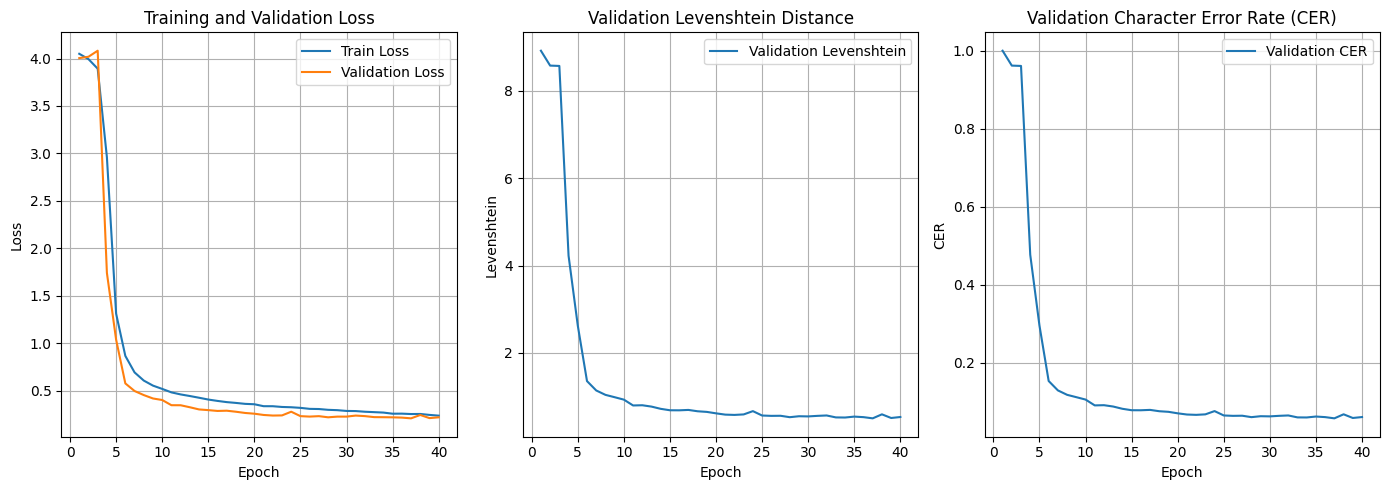


Загрузка лучшей модели для анализа: morse_crnn_4layer_norm_aug_v1_best_ep37_lev0.5057.pth
Модель CRNNModel_4Layer: Выход CNN для RNN = 2048 признаков (C=128, F'=16)
Модель CRNNModel_4Layer: Фактор сокращения времени CNN = 16x
Лучшая модель загружена.

Расчет финальных метрик и Confusion Matrix на валидационной выборке...


/tmp/ipykernel_31/2581840166.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(best_checkpoint_path, map_location=DEVICE)


Final Validation:   0%|          | 0/47 [00:00<?, ?it/s]


Финальные метрики на Validation Set (Best Model, Greedy Decode):
  - Levenshtein Distance: 0.5057
  - Character Error Rate (CER): 0.0567
Ошибка построения Confusion Matrix: Found input variables with inconsistent numbers of samples: [26733, 26503]


In [14]:
print("\n--- Анализ Результатов Обучения ---")

# --- Графики Loss и Метрик ---
if history['train_loss']:
    epochs_range = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, history['train_loss'], label='Train Loss')
    plt.plot(epochs_range, history['val_loss'], label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    plt.subplot(1, 3, 2)
    plt.plot(epochs_range, history['val_metric'], label='Validation Levenshtein')
    plt.legend(loc='upper right')
    plt.title('Validation Levenshtein Distance')
    plt.xlabel('Epoch')
    plt.ylabel('Levenshtein')
    plt.grid(True)

    plt.subplot(1, 3, 3)
    plt.plot(epochs_range, history['val_cer'], label='Validation CER')
    plt.legend(loc='upper right')
    plt.title('Validation Character Error Rate (CER)')
    plt.xlabel('Epoch')
    plt.ylabel('CER')
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Нет данных истории для построения графиков.")

# --- Загрузка лучшей модели и расчет финальных метрик на Val ---
best_model = None
best_checkpoint_path = None
if best_epoch != -1:
     try:
        # Ищем чекпоинт с лучшей метрикой
        checkpoints = [f for f in os.listdir(config["CHECKPOINT_DIR"]) if f.startswith(config['MODEL_NAME']) and f.endswith(".pth")]
        best_filename = f"{config['MODEL_NAME']}_best_ep{best_epoch}_lev{best_val_metric:.4f}.pth"
        if best_filename in checkpoints:
            best_checkpoint_path = os.path.join(config["CHECKPOINT_DIR"], best_filename)
        else: # Если имя файла немного отличается из-за округления
            best_metric_found = float('inf')
            for fname in checkpoints:
                 try:
                     metric_val = float(fname.split('_lev')[-1].replace('.pth',''))
                     if abs(metric_val - best_val_metric) < 1e-5: # Ищем очень близкое значение
                          best_checkpoint_path = os.path.join(config["CHECKPOINT_DIR"], fname)
                          break
                 except: continue

        if best_checkpoint_path and os.path.exists(best_checkpoint_path):
            print(f"\nЗагрузка лучшей модели для анализа: {os.path.basename(best_checkpoint_path)}")
            checkpoint = torch.load(best_checkpoint_path, map_location=DEVICE)
            # Загружаем конфиг из чекпоинта, чтобы создать модель с теми же параметрами
            loaded_config = checkpoint['config']
            # Важно: используем параметры из ЗАГРУЖЕННОГО конфига
            if loaded_config['MODEL']['type'] == 'CRNNModel_4Layer':
                best_model = CRNNModel_4Layer(
                    n_features=loaded_config['AUDIO']['n_mels'], num_classes=len(checkpoint['char_to_int']),
                    rnn_hidden_size=loaded_config['MODEL']['rnn_hidden_size'], num_rnn_layers=loaded_config['MODEL']['rnn_num_layers'],
                    cnn_dropout=0.0, rnn_dropout=0.0 # Dropout в eval обычно отключают
                ).to(DEVICE)
            else: raise ValueError("Неизвестный тип модели в чекпоинте")

            best_model.load_state_dict(checkpoint['model_state_dict'])
            best_model.eval()
            print("Лучшая модель загружена.")
        else: print("Не удалось найти файл лучшего чекпоинта.")

     except Exception as e: print(f"Ошибка загрузки лучшей модели: {e}")
else:
    print("Лучшая модель не сохранялась во время обучения.")


# --- Расчет CER и Confusion Matrix на Validation Set ---
if best_model:
    print("\nРасчет финальных метрик и Confusion Matrix на валидационной выборке...")
    all_val_preds_final, all_val_targets_final = [], []
    val_iter_final = tqdm(val_loader, desc="Final Validation", leave=False)
    with torch.no_grad():
        for batch in val_iter_final:
            try:
                if not isinstance(batch, (tuple, list)) or len(batch) != 4 or batch[0].numel() == 0: continue
                spec_batch, spec_len_batch, target_batch, target_len_batch = batch
                spec_batch = spec_batch.to(DEVICE)

                log_probs, output_lengths = best_model(spec_batch, spec_len_batch.to(DEVICE))
                output_lengths = torch.clamp(output_lengths, max=log_probs.shape[0])

                # Используем Greedy декодирование для этого анализа
                batch_preds = decode_predictions(log_probs, int_to_char, blank_index)
                batch_targets = decode_targets(target_batch, target_len_batch, int_to_char)
                all_val_preds_final.extend(batch_preds)
                all_val_targets_final.extend(batch_targets)
            except Exception as e: print(f"Ошибка финальной валидации: {e}"); continue

    if all_val_targets_final:
        final_lev = calculate_levenshtein_mean(all_val_preds_final, all_val_targets_final)
        final_cer = calculate_cer(all_val_preds_final, all_val_targets_final)
        print(f"\nФинальные метрики на Validation Set (Best Model, Greedy Decode):")
        print(f"  - Levenshtein Distance: {final_lev:.4f}")
        print(f"  - Character Error Rate (CER): {final_cer:.4f}")

        # --- Confusion Matrix ---
        try:
            # Собираем все символы из предсказаний и таргетов для матрицы
            pred_chars = "".join(all_val_preds_final)
            target_chars = "".join(all_val_targets_final)
            # Ограничим длину для производительности, если нужно
            max_len_cm = 50000
            if len(target_chars) > max_len_cm:
                 indices = np.random.choice(len(target_chars), max_len_cm, replace=False)
                 pred_chars = "".join(np.array(list(pred_chars))[indices])
                 target_chars = "".join(np.array(list(target_chars))[indices])
                 print(f"(Матрица ошибок построена на {max_len_cm} случайных символах)")


            # Уникальные символы (включая те, что могли быть в таргете, но не в предсказании, и наоборот)
            labels = sorted(list(set(pred_chars) | set(target_chars)))
            if not labels: raise ValueError("Нет символов для матрицы ошибок")

            cm = confusion_matrix(list(target_chars), list(pred_chars), labels=labels)
            cm_df = pd.DataFrame(cm, index=labels, columns=labels)

            plt.figure(figsize=(12, 10))
            sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix - Validation Set (Best Model)')
            plt.ylabel('Actual Characters')
            plt.xlabel('Predicted Characters')
            plt.show()

            # Вывод часто ошибаемых пар (опционально)
            errors = []
            for i, label_true in enumerate(labels):
                for j, label_pred in enumerate(labels):
                    if i != j and cm[i, j] > 0:
                        errors.append(((label_true, label_pred), cm[i, j]))
            if errors:
                 errors.sort(key=lambda item: item[1], reverse=True)
                 print("\nНаиболее частые ошибки (True -> Pred):")
                 for pair, count in errors[:15]: # Показать топ 15
                      print(f"  '{pair[0]}' -> '{pair[1]}': {count}")

        except Exception as e: print(f"Ошибка построения Confusion Matrix: {e}")
    else:
         print("Не удалось получить предсказания/таргеты для финального анализа.")
else:
    print("Анализ невозможен, так как лучшая модель не была загружена.")

### Ячейка 13: Инференс на Тестовой Выборке

In [15]:
print("\n--- Инференс на Тестовой Выборке ---")
inference_model = None; test_loader_inf = None; decoder_bs = None
int_to_char_inf = None; blank_index_inf = -1
loaded_config_inf = None # Хранит конфиг загруженного чекпоинта

try:
    # --- 1. Поиск и Загрузка лучшей модели ---
    if not os.path.isdir(config["CHECKPOINT_DIR"]): raise FileNotFoundError(f"Папка {config['CHECKPOINT_DIR']} не найдена")
    inf_checkpoints = []
    for filename in os.listdir(config["CHECKPOINT_DIR"]):
        if filename.startswith(config['MODEL_NAME']) and filename.endswith(".pth") and '_lev' in filename:
            try: inf_checkpoints.append((float(filename.split('_lev')[-1].replace('.pth','')), filename))
            except: continue
    if not inf_checkpoints: raise FileNotFoundError(f"Чекпоинты не найдены в {config['CHECKPOINT_DIR']} для {config['MODEL_NAME']}")

    inf_checkpoints.sort(); best_metric_inf, best_filename_inf = inf_checkpoints[0]
    best_checkpoint_path_inf = os.path.join(config["CHECKPOINT_DIR"], best_filename_inf)
    print(f"Используем лучший чекпоинт: {best_filename_inf} (Val Lev: {best_metric_inf:.4f})")
    checkpoint_inf = torch.load(best_checkpoint_path_inf, map_location=DEVICE)

    # --- Загрузка конфигурации из чекпоинта ---
    if 'config' not in checkpoint_inf: raise ValueError("Конфигурация не найдена в чекпоинте!")
    loaded_config_inf = checkpoint_inf['config']
    char_to_int_inf = checkpoint_inf['char_to_int']; int_to_char_inf = checkpoint_inf['int_to_char']
    blank_index_inf = checkpoint_inf['blank_index']
    NUM_CLASSES_INF = len(char_to_int_inf)

    # --- Пересоздание модели с ЗАГРУЖЕННЫМИ параметрами ---
    model_cfg_inf = loaded_config_inf['MODEL']
    audio_cfg_inf = loaded_config_inf['AUDIO']
    n_features_inf = audio_cfg_inf['n_mels']

    if model_cfg_inf['type'] == 'CRNNModel_4Layer':
         inference_model = CRNNModel_4Layer(
            n_features=n_features_inf, num_classes=NUM_CLASSES_INF,
            rnn_hidden_size=model_cfg_inf['rnn_hidden_size'], num_rnn_layers=model_cfg_inf['rnn_num_layers'],
            cnn_dropout=0.0, rnn_dropout=0.0 # Отключаем dropout для инференса
        ).to(DEVICE)
    else: raise ValueError(f"Неизвестный тип модели в конфиге чекпоинта: {model_cfg_inf['type']}")

    inference_model.load_state_dict(checkpoint_inf['model_state_dict'])
    inference_model.eval()
    print("Модель для инференса загружена.")

    # --- 2. Создание Тестового Лоадера (с ПРЕДОБРАБОТКОЙ из конфига чекпоинта!) ---
    test_df = pd.read_csv(config["TEST_CSV_PATH"])
    test_dataset_inf = MorseDataset(
        data_frame=test_df, audio_base_path=config["AUDIO_BASE_PATH"], char_map=None, # char_map=None для теста
        file_path_column=config["FILE_PATH_COLUMN"], target_column="__IGNORE__",
        audio_cfg=loaded_config_inf["AUDIO"], # Используем аудио конфиг из чекпоинта
        preproc_cfg=loaded_config_inf["PREPROCESSING"], # Используем препроцессинг из чекпоинта
        aug_cfg=None, # НИКАКИХ АУГМЕНТАЦИЙ на тесте
        is_train=False
    )
    test_loader_inf = DataLoader(test_dataset_inf, batch_size=config['INFERENCE']['batch_size'], shuffle=False,
                             collate_fn=collate_fn_test, num_workers=0) # num_workers=0 может быть стабильнее для инференса
    print(f"Тестовый лоадер создан ({len(test_dataset_inf)} сэмплов).")

    # --- 3. Настройка Beam Search Декодера (Опционально) ---
    use_beam_search_inf = config['INFERENCE']['use_beam_search'] and TORCHAUDIO_CTC_DECODER_AVAILABLE and ctc_decoder
    if use_beam_search_inf:
        try:
            labels_inf = [int_to_char_inf[i] for i in range(NUM_CLASSES_INF)]
            decoder_bs = ctc_decoder(
                lexicon=config['INFERENCE'].get('beam_search_lexicon_path'), # None если не указан
                tokens=labels_inf,
                lm=config['INFERENCE'].get('beam_search_lm_path'),           # None если не указан
                nbest=1,
                beam_size=config['INFERENCE']['beam_search_beam_size'],
                blank_token=BLANK_CHAR,
                sil_token=BLANK_CHAR, # Используем бланк как тишину
                unk_word=BLANK_CHAR   # Используем бланк как неизвестное слово
            )
            print(f"CTCDecoder (Beam Size: {config['INFERENCE']['beam_search_beam_size']}, LM: {'Yes' if config['INFERENCE']['beam_search_lm_path'] else 'No'}) создан.")
        except Exception as e:
            print(f"Ошибка создания CTCDecoder: {e}. Используем Greedy.")
            decoder_bs = None # Откат на Greedy
    else:
        print("Beam Search недоступен или отключен. Используем Greedy.")

except Exception as e: print(f"Ошибка подготовки инференса: {e}"); traceback.print_exc()

# --- 4. Запуск Инференса ---
submission_results = []
if inference_model and test_loader_inf and int_to_char_inf:
    print(f"\n--- Запуск инференса ({'Beam Search' if decoder_bs else 'Greedy'}) ---")
    inference_start_time = time.time(); inference_model.eval()
    test_iter = tqdm(test_loader_inf, desc=f"Inference ({'Beam Search' if decoder_bs else 'Greedy'})")

    with torch.no_grad():
        for batch_idx, batch in enumerate(test_iter):
            if not isinstance(batch, (tuple, list)) or len(batch) != 3 or batch[0].numel() == 0: continue
            spec_batch, spec_len_batch, ids_batch = batch
            spec_batch = spec_batch.to(DEVICE)
            try:
                log_probs, output_lengths = inference_model(spec_batch, spec_len_batch.to(DEVICE))
                output_lengths = torch.clamp(output_lengths, max=log_probs.shape[0])
                batch_preds = []

                if decoder_bs: # Beam Search
                    emissions_p = log_probs.permute(1, 0, 2).contiguous().cpu() # Decoder ожидает [B, T, C]
                    lengths_c = output_lengths.cpu() # Decoder ожидает длины на CPU
                    # Запускаем декодер
                    hypotheses = decoder_bs(emissions_p, lengths_c)
                    # Обрабатываем результат
                    for hyps in hypotheses:
                        if hyps:
                            # Приводим токены к строке
                            pred_str = "".join([int_to_char_inf.get(idx, '?') for idx in hyps[0].tokens.tolist()])
                            batch_preds.append(pred_str)
                        else:
                             batch_preds.append("") # Если декодер ничего не вернул
                else: # Greedy
                    batch_preds = decode_predictions(log_probs, int_to_char_inf, blank_index_inf)

                # Сохраняем результаты батча
                for test_id, pred in zip(ids_batch, batch_preds):
                     submission_results.append({'id': str(test_id), 'message': pred})

            except Exception as e:
                print(f"\nОшибка инференса батч {batch_idx}: {e}")
                # traceback.print_exc() # Можно раскомментировать для детальной отладки
                for test_id in ids_batch: submission_results.append({'id': str(test_id), 'message': '[INFERENCE_ERROR]'})
                continue # Продолжаем со следующим батчем

    inference_time = time.time() - inference_start_time
    print(f"Инференс завершен за {inference_time:.1f} сек. Предсказаний: {len(submission_results)}")
else: print("Инференс не выполнен (ошибка подготовки).")


--- Инференс на Тестовой Выборке ---
Используем лучший чекпоинт: morse_crnn_4layer_norm_aug_v1_best_ep37_lev0.5057.pth (Val Lev: 0.5057)
Модель CRNNModel_4Layer: Выход CNN для RNN = 2048 признаков (C=128, F'=16)
Модель CRNNModel_4Layer: Фактор сокращения времени CNN = 16x
Модель для инференса загружена.
Тестовый лоадер создан (5000 сэмплов).
CTCDecoder (Beam Size: 15, LM: No) создан.

--- Запуск инференса (Beam Search) ---


/tmp/ipykernel_31/3091761441.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_inf = torch.load(best_checkpoint_path_inf, map_location=DEVICE)


Inference (Beam Search):   0%|          | 0/79 [00:00<?, ?it/s]

Инференс завершен за 154.7 сек. Предсказаний: 5000


### Ячейка 14: Создание Файла Submission

In [16]:
SUBMISSION_TARGET_COLUMN = 'message'
if not submission_results: print("Нет результатов для сабмита.")
else:
    submission_df = pd.DataFrame(submission_results); print(f"Получено {len(submission_df)} предсказаний.")
    try:
        sample_df = pd.read_csv(config["SAMPLE_SUBMISSION_PATH"]); print(f"Загружен sample: {config['SAMPLE_SUBMISSION_PATH']}")
        submission_df['id'] = submission_df['id'].astype(str); sample_df['id'] = sample_df['id'].astype(str)
        if submission_df['id'].duplicated().any(): submission_df = submission_df.drop_duplicates(subset=['id'], keep='first')
        final_submission = pd.merge(sample_df[['id']], submission_df[['id', SUBMISSION_TARGET_COLUMN]], on='id', how='left')
        missing_preds = final_submission[SUBMISSION_TARGET_COLUMN].isnull().sum()
        if missing_preds > 0: print(f"ПРЕДУПРЕЖДЕНИЕ: {missing_preds} ID не найдены, заполнены пустыми строками."); final_submission[SUBMISSION_TARGET_COLUMN] = final_submission[SUBMISSION_TARGET_COLUMN].fillna('')
        if len(final_submission) != len(sample_df): print(f"ПРЕДУПРЕЖДЕНИЕ: Размер сабмита ({len(final_submission)}) не совпадает с sample ({len(sample_df)})!")
        else: print("Размер совпадает с sample_submission.")
        final_submission[['id', SUBMISSION_TARGET_COLUMN]].to_csv(config["SUBMISSION_FILE"], index=False)
        print(f"\nФайл submission сохранен: {config['SUBMISSION_FILE']}"); display(final_submission[['id', SUBMISSION_TARGET_COLUMN]].head())
    except FileNotFoundError: print(f"Не найден {config['SAMPLE_SUBMISSION_PATH']}. Сохраняем как есть."); submission_df[['id', SUBMISSION_TARGET_COLUMN]].to_csv(config["SUBMISSION_FILE"], index=False)
    except Exception as e: print(f"Ошибка создания submission файла: {e}"); traceback.print_exc()

Получено 5000 предсказаний.
Загружен sample: /kaggle/input/morse-dataset/data/sample_submission.csv
Размер совпадает с sample_submission.

Файл submission сохранен: /kaggle/working/submission_morse_crnn_4layer_norm_aug_v1.csv


,id,message
0,30001.opus,ЯЮ6ЛИТЖБШ
1,30002.opus,КЩ В9Ю 9
2,30003.opus,Ы65Ф61Я
3,30004.opus,ЖЖНЖ9РЫНЦ3
4,30005.opus,ЕЯФ4ЮЧЬ
